# Balzax environments

***To be run on Collab***

## Imports and modules

### Install Flax

In [1]:
!pip install flax

     |████████████████████████████████| 186 kB 5.5 MB/s 
     |████████████████████████████████| 140 kB 6.0 MB/s 
     |████████████████████████████████| 72 kB 375 kB/s 


### Install Balzax

In [2]:
!pip install git+https://github.com/charlypg/Balzax@main

  Cloning https://github.com/charlypg/Balzax (to revision main) to /tmp/pip-req-build-5bcsrffo
  Running command git clone -q https://github.com/charlypg/Balzax /tmp/pip-req-build-5bcsrffo
  Created wheel for balzax: filename=balzax-0.0.3-py3-none-any.whl size=15125 sha256=b15efe9596f7e0df821a161af6db6989c797ddb5da9434336203113f17bb7743
  Stored in directory: /tmp/pip-ephem-wheel-cache-v9nss7ym/wheels/44/41/68/a79f1aa3f5d7c053785d9ce2f2259c0b917a04e4149ad24e72
Successfully built balzax


### Imports

In [3]:
import jax
import jax.numpy as jnp
import flax
from functools import partial
from time import time 
import matplotlib.pyplot as plt
from tqdm import tqdm

from balzax import BallsEnv, BallsEnvGoal

### Devices

In [4]:
print(jax.devices())

[GpuDevice(id=0, process_index=0)]


## Reset vs Reset Done

In [5]:
def gen_keys(seed, num):
  return jax.random.split(jax.random.PRNGKey(seed), num=num)

NUM_ENV = 100
NB_ITER = 1_000
env = BallsEnvGoal(obs_type='position', max_timestep=50)
vmap_env_reset_done = jax.jit(jax.vmap(env.reset_done), backend='gpu') 
vmap_env_reset = jax.jit(jax.vmap(env.reset), backend='gpu')  

reset_times = []
reset_done_times = []

for seed in tqdm(range(NB_ITER)):
  keys = gen_keys(seed, NUM_ENV)
  t0 = time()
  env_state = vmap_env_reset(keys)
  reset_times.append(time()-t0)

for _ in tqdm(range(NB_ITER)):
  t0 = time()
  env_state = vmap_env_reset_done(env_state)
  reset_done_times.append(time()-t0)

sum_reset = sum(reset_times)
print("Mean reset: {}s".format(sum_reset/len(reset_times)))
print("Sum resets: {}s".format(sum_reset))
print()

sum_reset_dones = sum(reset_done_times)
print("Mean reset_done: {}s".format(sum_reset_dones/len(reset_done_times)))
print("Sum reset_dones: {}s".format(sum_reset_dones))
print()

100%|██████████| 1000/1000 [00:03<00:00, 325.73it/s]

Mean reset: 0.00163826847076416s
Sum resets: 1.6382684707641602s

Mean reset_done: 0.0030111296176910402s
Sum reset_dones: 3.01112961769104s



## Testing vectorized BallsEnv

In [6]:
OBS_TYPE = 'image' # @param ['position', 'image']
MAX_TIMESTEPS = 3
SEED = 0
NUM_ENV = 500

NB_ITER_1 = 1
NB_ITER_2 = 500

ACTION_0 = jnp.zeros((NUM_ENV, 1))
ACTION_1 = jnp.ones((NUM_ENV, 1))/2.

key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, num=NUM_ENV)

env = BallsEnv(obs_type=OBS_TYPE, max_timestep=MAX_TIMESTEPS)

vmap_env_reset_done = jax.jit(jax.vmap(env.reset_done), backend='gpu') 
vmap_env_reset = jax.jit(jax.vmap(env.reset), backend='gpu')  
vmap_env_step = jax.jit(jax.vmap(env.step), backend='gpu')  

print()
print("Observation type : {}".format(OBS_TYPE))
print("Seed : {}".format(SEED))
print("Number of envs : {}".format(NUM_ENV))
print()

t0 = time()
env_states = vmap_env_reset(keys)
print("Time of reset (jit+exec) : {}".format(time()-t0))
print()

print("observations : {}".format(env_states.obs.shape))
print()

t0 = time()
for _ in tqdm(range(NB_ITER_1)):
    env_states = vmap_env_step(env_states, ACTION_1)
    env_states = vmap_env_reset_done(env_states)
print("{0} iterations in {1}s".format(NB_ITER_1, time()-t0))
print("step and reset_done : first call reflecting compilation time")
print()

step_times = []
reset_done_times = []
pulse = 2*jnp.pi / NB_ITER_2 * jnp.ones((NUM_ENV, 1))
t0 = time()
for i in tqdm(range(NB_ITER_2)):
    t1 = time()
    env_states = vmap_env_step(env_states, jnp.sin(pulse*i))
    step_times.append(time()-t1)
    t1 = time()
    env_states = vmap_env_reset_done(env_states)
    reset_done_times.append(time()-t1)
print("{0} iterations in {1}s".format(NB_ITER_2, time()-t0))
print("step and reset_done")
print('\n\n')

sum_steps = sum(step_times)
print("Mean step: {}s".format(sum_steps/len(step_times)))
print("Sum steps: {}s".format(sum_steps))
print()

sum_reset_dones = sum(reset_done_times)
print("Mean reset_done: {}s".format(sum_reset_dones/len(reset_done_times)))
print("Sum reset_dones: {}s".format(sum_reset_dones))
print()


Observation type : image
Seed : 0
Number of envs : 500

Time of reset (jit+exec) : 1.2153356075286865

observations : (500, 224, 224, 1)



100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


1 iterations in 4.881577491760254s
step and reset_done : first call reflecting compilation time



100%|██████████| 500/500 [00:06<00:00, 77.56it/s]

500 iterations in 6.45752477645874s
step and reset_done



Mean step: 0.006255265235900879s
Sum steps: 3.1276326179504395s

Mean reset_done: 0.00632636833190918s
Sum reset_dones: 3.16318416595459s



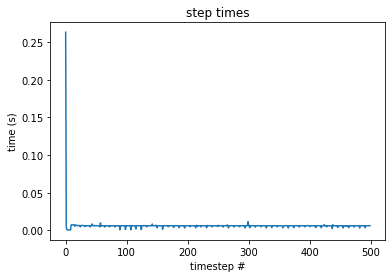

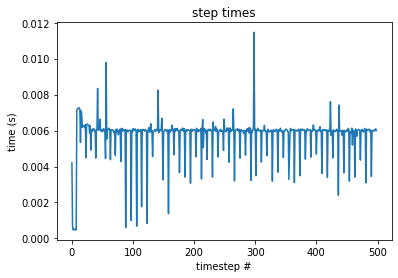

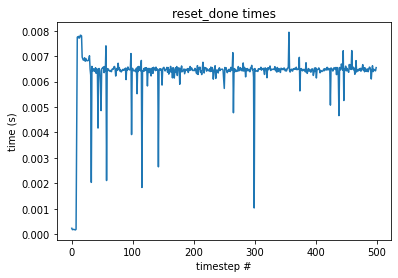

In [7]:
plt.figure(1)
plt.title("step times")
plt.xlabel('timestep #')
plt.ylabel('time (s)')
plt.plot(step_times)

plt.figure(2)
plt.title("step times")
plt.xlabel('timestep #')
plt.ylabel('time (s)')
plt.plot(step_times[1:])

plt.figure(3)
plt.title("reset_done times")
plt.xlabel('timestep #')
plt.ylabel('time (s)')
plt.plot(reset_done_times)

### Testing vectorized BallsEnvGoal

In [8]:
OBS_TYPE = 'position' # @param ['position', 'image']
MAX_TIMESTEPS = 100
SEED = 0
NUM_ENV = 10_000

NB_ITER_1 = 1
NB_ITER_2 = 10_000

ACTION_0 = jnp.zeros((NUM_ENV, 1))
ACTION_1 = jnp.ones((NUM_ENV, 1))/2.

key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, num=NUM_ENV)

env = BallsEnvGoal(obs_type=OBS_TYPE, max_timestep=MAX_TIMESTEPS)

vmap_env_reset_done = jax.jit(jax.vmap(env.reset_done), backend='gpu') 
vmap_env_reset = jax.jit(jax.vmap(env.reset), backend='gpu')  
vmap_env_step = jax.jit(jax.vmap(env.step), backend='gpu')  

print()
print("Observation type : {}".format(OBS_TYPE))
print("Seed : {}".format(SEED))
print("Number of envs : {}".format(NUM_ENV))
print()

t0 = time()
env_states = vmap_env_reset(keys)
print("Time of reset (jit+exec) : {}".format(time()-t0))
print()

for field, value in zip(env_states.goalobs.keys(), env_states.goalobs.values()):
  print("{0} : {1}".format(field, value.shape))
print()

t0 = time()
for _ in tqdm(range(NB_ITER_1)):
    env_states = vmap_env_step(env_states, ACTION_1)
    env_states = vmap_env_reset_done(env_states)
print("{0} iterations in {1}s".format(NB_ITER_1, time()-t0))
print("step and reset_done : first call reflecting compilation time")
print()

step_times = []
reset_done_times = []
pulse = 2*jnp.pi / NB_ITER_2 * jnp.ones((NUM_ENV, 1))
t0 = time()
for i in tqdm(range(NB_ITER_2)):
    t1 = time()
    env_states = vmap_env_step(env_states, jnp.sin(pulse*i))
    step_times.append(time()-t1)
    t1 = time()
    env_states = vmap_env_reset_done(env_states)
    reset_done_times.append(time()-t1)
print("{0} iterations in {1}s".format(NB_ITER_2, time()-t0))
print("step and reset_done")
print('\n\n')

sum_steps = sum(step_times)
print("Mean step: {}s".format(sum_steps/len(step_times)))
print("Sum steps: {}s".format(sum_steps))
print()

sum_reset_dones = sum(reset_done_times)
print("Mean reset_done: {}s".format(sum_reset_dones/len(reset_done_times)))
print("Sum reset_dones: {}s".format(sum_reset_dones))
print()


Observation type : position
Seed : 0
Number of envs : 10000

Time of reset (jit+exec) : 0.8918647766113281

achieved_goal : (10000, 8)
desired_goal : (10000, 8)
observation : (10000, 8)



100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


1 iterations in 9.701481819152832s
step and reset_done : first call reflecting compilation time



100%|██████████| 10000/10000 [00:37<00:00, 268.55it/s]

10000 iterations in 37.24441051483154s
step and reset_done



Mean step: 0.0006712950706481934s
Sum steps: 6.712950706481934s

Mean reset_done: 0.0029443795919418337s
Sum reset_dones: 29.443795919418335s



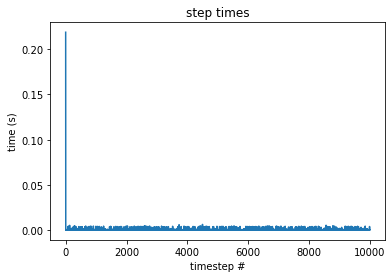

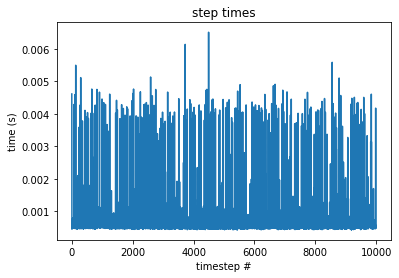

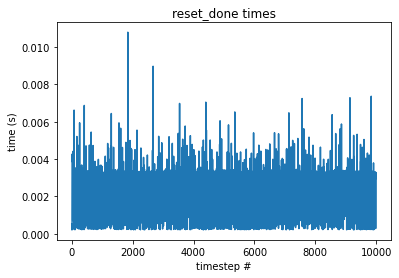

In [9]:
plt.figure(1)
plt.title("step times")
plt.xlabel('timestep #')
plt.ylabel('time (s)')
plt.plot(step_times)

plt.figure(2)
plt.title("step times")
plt.xlabel('timestep #')
plt.ylabel('time (s)')
plt.plot(step_times[1:])

plt.figure(3)
plt.title("reset_done times")
plt.xlabel('timestep #')
plt.ylabel('time (s)')
plt.plot(reset_done_times)